Explanation of notebooks: 

- The $\textbf{Exoplanet Practice notebook}$ models the transits for the planetary system, and subtracts the model from the pld data to see if histogram of noise is gaussian. This notebook finds there is lots of non-gaussian noise, indiciating a bug. 
- The $\textbf{Outliers Removal - Histogram-bug notebook}$ tries using MAST lightkurve instead of pld but still replicates this bug.
- The $\textbf{TPF files notebook}$ explains why the pld data had weird features. If I stitch lightcurves from different quarters and then flatten them, they introduce those features. If I flatten each quarter and THEN stitch, the features are no longer there. 
- The $\textbf{Outliers Removal - Histogram-pld notebook}$ goes back to using pld but fixes the bug (found to be using the wrong time array in exoplanet model). This notebook also tries to explore the pld data's weird featurues  
- The $\textbf{Outliers Removal - Histogram-sap notebook}$ tries using sap but fixes the time array bug 
- The $\textbf{Outliers Removal - Histogram notebook}$ uses MAST lightkurve and fixes the bug (found to be using the wrong time array in exoplanet model). Histogram looks good but folded light curve found to have shoulders. 

The MAST lightkurve + time array bug fix was the combination that led to the least amount of outliers. However, the folded light curve had shoulders, so flattening needs to be removed. 


In [3]:
import exoplanet as xo 
import lightkurve as lk 
import astropy.units as units
import matplotlib.pyplot as plt 
import numpy as np 
import math
%matplotlib inline
from astropy.time import Time 
import sys 
sys.path.append("helpers")
import data 
import xo_archive
import fit
xo.utils.docs_setup()
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.family'] = 'DeJavu Serif'
import matplotlib.font_manager
from scipy.stats import norm 
import statistics
from importlib import reload
import pymc3 as pm
import pymc3_ext as pmx

reload(fit)

<module 'fit' from '/Users/suissa/radius-valley/helpers/fit.py'>

In [4]:
planet_parameters = xo_archive.get_exoplanet_parameters("Kepler-109 ", which="composite")
param_lists = xo_archive.transpose_parameters(planet_parameters)


students-t distribution incompatible with Gaussian Processes 
correlated noise - multidimensional GP 

1) outliers could be due to flares, poor fit to the data, systematics 
2) systematic noise - pointing drift 
3) stellar correlations 

Ideally need a probability distribution to account for all of these 

1 and 3 are basically impossible to implement simultaneously 
1 use histogram or CDF 
2 look at correlation between x/y position vs the flux 

need to look if theres any correlation in x and y positions 

PLD - look at it in the lightkurve package, should have removed large dips 

ACF for 3 - auto correlation function 

# seeing if using the lk lightcurves instead works 

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans


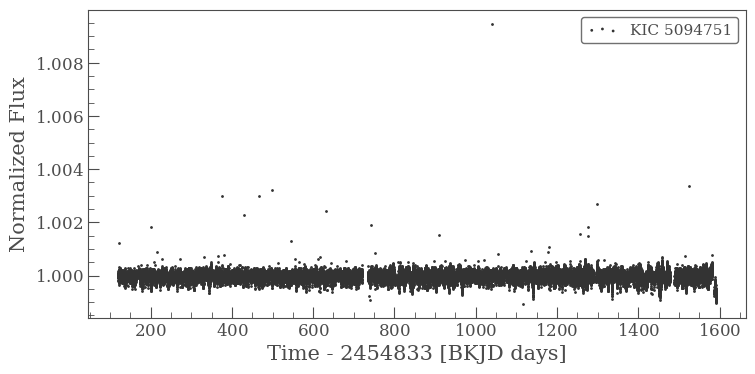

In [5]:
# Flattening first and then stitching MAST lightcurves 
# also fixed time array bug 

search_results = lk.search_lightcurve("Kepler-109", mission="Kepler", exptime=1800)
lcc = search_results.download_all()
#lcc = [i.flatten() for i in lcc]
#lcc = lk.LightCurveCollection(lightcurves=lcc)
lc = lcc.stitch().remove_nans()
lc.scatter()

(200.0, 600.0)

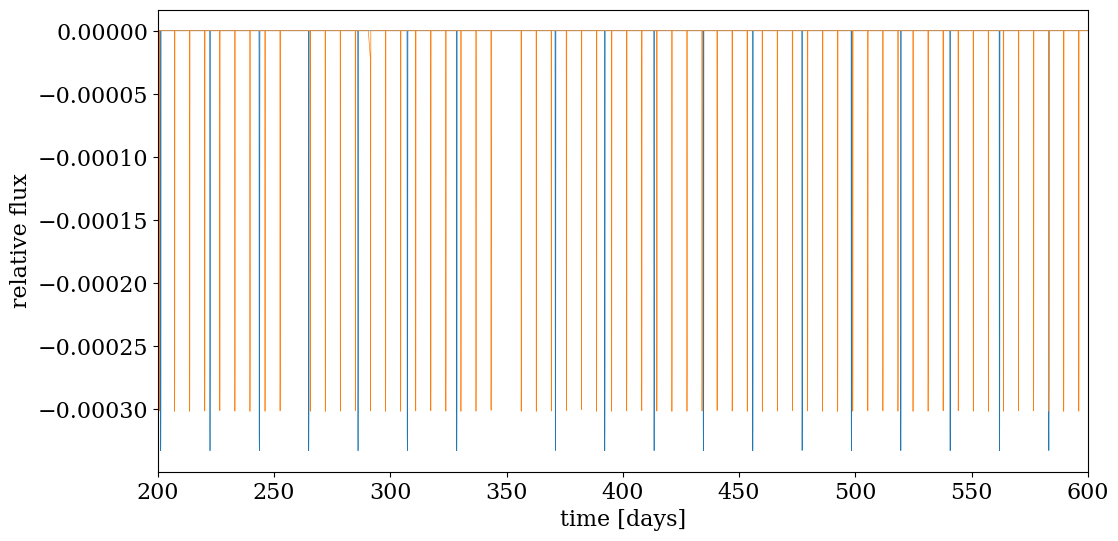

In [6]:
constant = 1

orbits = {}
for i in range(len(param_lists['pl_letter'])):
    orbits[param_lists['pl_letter'][i]] = xo.orbits.SimpleTransitOrbit(period=param_lists["pl_orbper"][i], t0=(Time(param_lists["pl_tranmid"][i],
                                 format="jd").bkjd),b=param_lists['pl_imppar'][i], duration=param_lists['pl_trandur'][i]/24,
                                                                   r_star=param_lists['st_rad'][i],ror=param_lists['pl_ratror'][i])
t = lc.time.value
u = [0.2, 0.2]

light_curves = {}
for i in range(len(param_lists['pl_letter'])):
    light_curves[param_lists['pl_letter'][i]] = (xo.LimbDarkLightCurve(*u).get_light_curve(orbit=orbits[param_lists['pl_letter'][i]], r=param_lists['st_rad'][i]*param_lists['pl_ratror'][i],t=t)
    .eval())

plt.figure(figsize=(12,6))
plt.plot(t, light_curves['c'], color="C0", lw=0.5)
plt.plot(t, light_curves['b'], color="C1", lw=0.5)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(200,600)

In [45]:
dataset = np.array(lc.flux)
model = light_curves['c']+light_curves['b']

(array([    0,     1,     2, ..., 65260, 65261, 65262]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [38]:
model = model.flatten()

In [39]:
difference = (dataset - model)

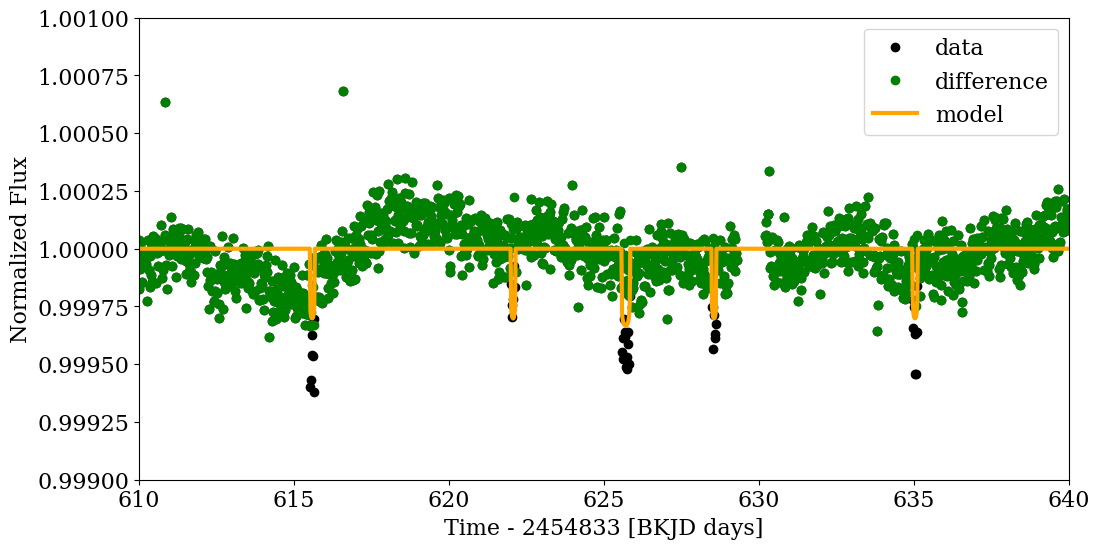

In [40]:
p = lc.scatter()
plt.close()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(lc.time.value,lc.flux.value,color='k',marker='o',ls='',label='data')
plt.plot(lc.time.value,difference,marker='o',ls='',color='green',label='difference')
plt.plot(t, model+1,color='orange',lw=3,label='model')
plt.xlabel(p.get_xlabel())
plt.ylabel(p.get_ylabel())
plt.xlim(610,640)
plt.ylim(0.999, 1.001)
plt.legend()

(0.9994, 1.0006)

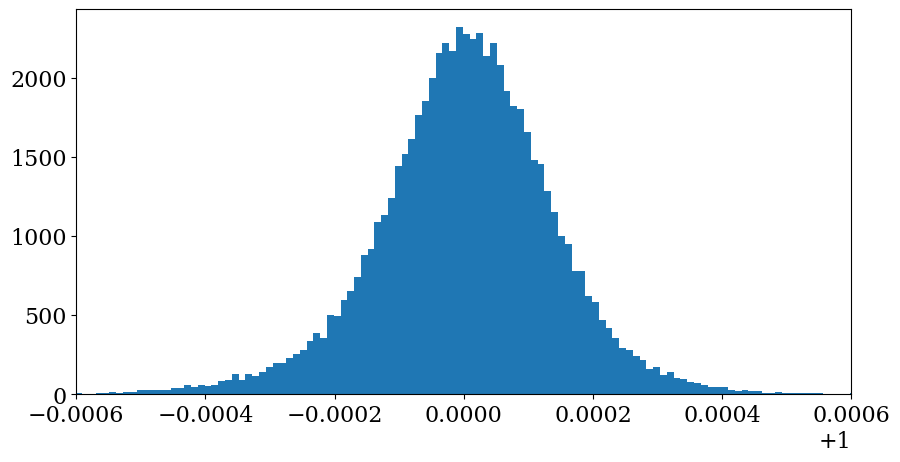

In [41]:
plt.figure(figsize=(10,5))
plt.hist(difference, bins=1000)
plt.xlim(0.9994, 1.0006)

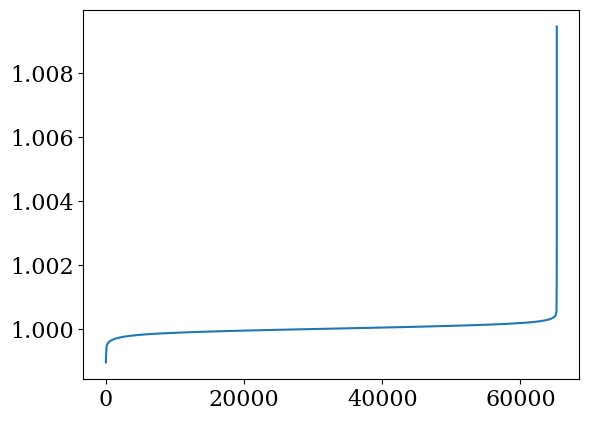

In [42]:
diff_sorted = np.sort(difference)
N = len(diff_sorted)
p = np.arange(N)
plt.plot(p, diff_sorted)

In [43]:
# find the two points to get std 

f = lambda x: np.interp(x, p, diff_sorted)

one_sigma_pos = f((0.8413)*N)
one_sigma_neg = f((1-0.8413)*N)
print(one_sigma_neg, one_sigma_pos)

std_calculated = (one_sigma_pos - one_sigma_neg)/2
print(std_calculated)


0.9998788833618164 1.0001277923583984
0.00012445449829101562


(0.999, 1.001)

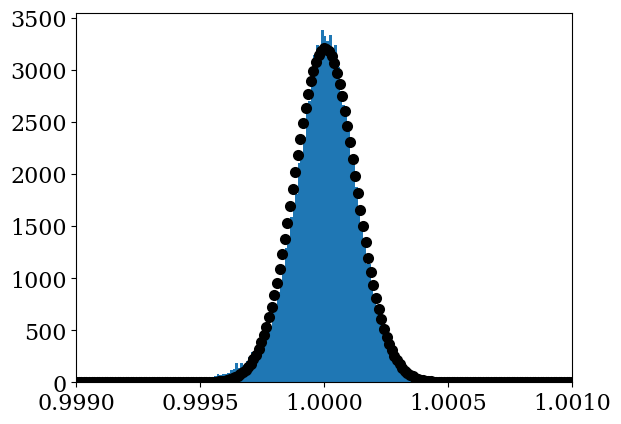

In [44]:
mu, std = norm.fit(difference)  
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.scatter(bins, norm(mu, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mu-(2*std_calculated),color='k')
#plt.axvline(mu+(2*std_calculated),color='k')
plt.xlim(0.999,1.001)

In [45]:
# note how we use the median as the center point to cut around 
mean_tweaked = np.mean(difference[((np.median(difference) - std_calculated) < difference) & (difference < (np.median(difference) + std_calculated))])
print(mean_tweaked)

1.000006770761828


In [2]:
norm_cdf = norm.cdf((diff_sorted - mean_tweaked)/std_calculated)

diff_sorted = np.sort(difference)
N = len(diff_sorted)
p = np.arange(N)
plt.plot(p, diff_sorted)
plt.plot(norm_cdf*N, diff_sorted)
plt.axhline(mean_tweaked,color='k')
plt.axhline(mean_tweaked-std_calculated,color='k')
plt.axhline(mean_tweaked+std_calculated,color='k')
plt.ylim(0.9995,1.0005)

NameError: name 'norm' is not defined

In [47]:
# find separation of curves 

(0.999, 1.001)

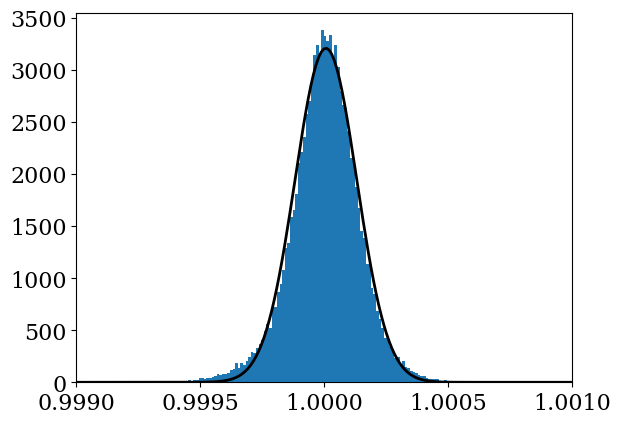

In [48]:
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.plot(bins, norm(mean_tweaked, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mean_tweaked-(std_calculated),color='k')
#plt.axvline(mean_tweaked+(std_calculated),color='k')
#plt.axvline(mean_tweaked-(2*std_calculated),color='k')
#plt.axvline(mean_tweaked+(2*std_calculated),color='k')
#plt.ylim(1e-6,5000)
plt.xlim(0.999,1.001)
#plt.yscale('log')

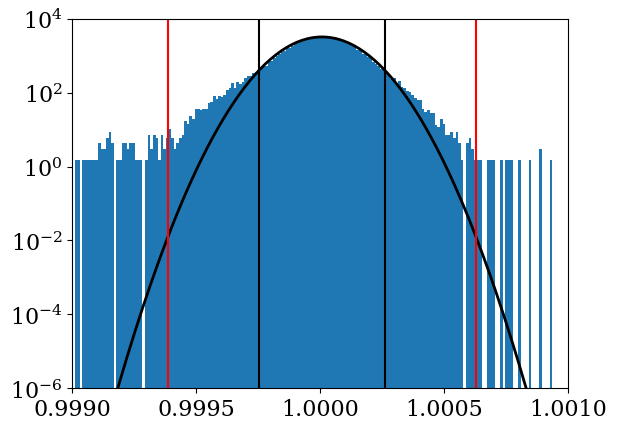

In [49]:
h, bins = np.histogram(difference, bins=1000)
plt.hist(difference, bins=bins, density=True)
plt.plot(bins, norm(mean_tweaked, std_calculated).pdf(bins), linewidth=2, color='black')
#plt.axvline(mean_tweaked-(std_calculated),color='k')
#plt.axvline(mean_tweaked+(std_calculated),color='k')
plt.axvline(mean_tweaked-(5*std_calculated),color='red')
plt.axvline(mean_tweaked+(5*std_calculated),color='red')
plt.ylim(1e-6,1e4)
plt.xlim(0.999,1.001)
plt.axvline(1.00026,color='k')
plt.axvline((2*mean_tweaked)-1.00026,color='k')
plt.yscale('log')

## now trying 5 sigma, no clumping 

In [1]:
flags_5sigma = ((mean_tweaked-(5*std_calculated)) > difference) | ((mean_tweaked+(5*std_calculated)) < difference)

NameError: name 'mean_tweaked' is not defined

(600.0, 700.0)

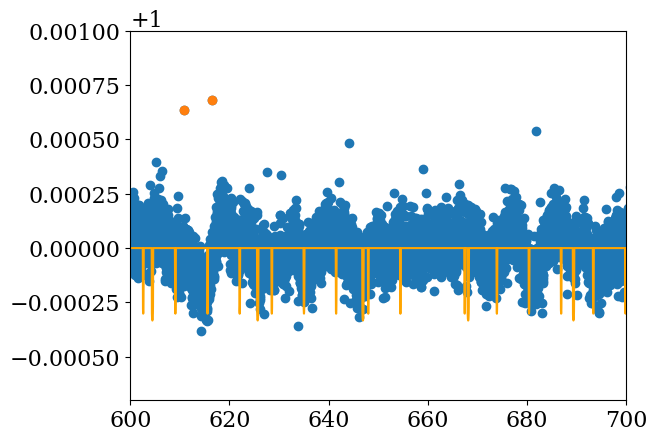

In [68]:
plt.scatter(lc.time.value, difference)
plt.scatter(lc.time.value[flags_5sigma], difference[flags_5sigma])
plt.plot(lc.time.value, model+1,color='orange')
plt.ylim(0.9993, 1.001)
plt.xlim(600,700)

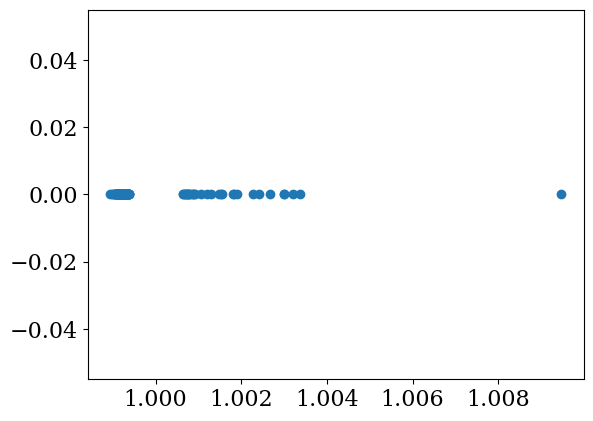

In [69]:
plt.scatter(difference[flags_5sigma],model[flags_5sigma])
#plt.xlim(0.999,1.0005)

In [70]:
lc_clean = lc[~flags_5sigma]

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

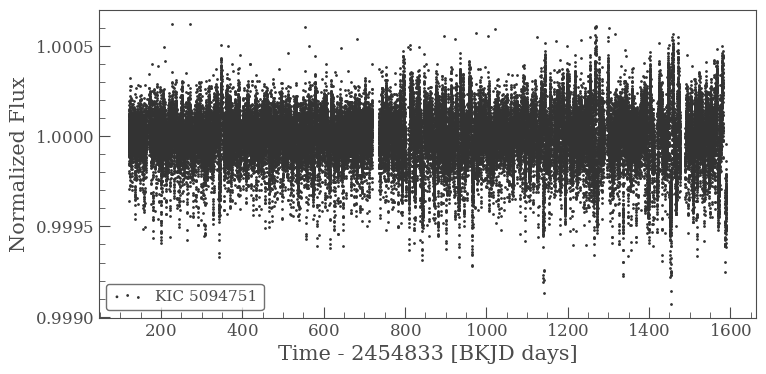

In [71]:
lc_clean.scatter()

## no shoulders now that flattening is removed

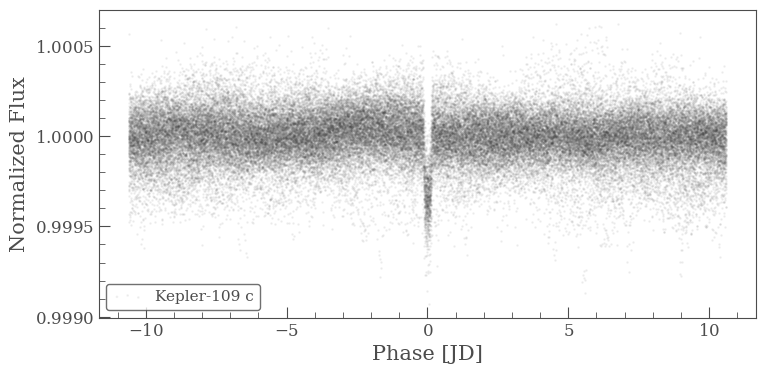

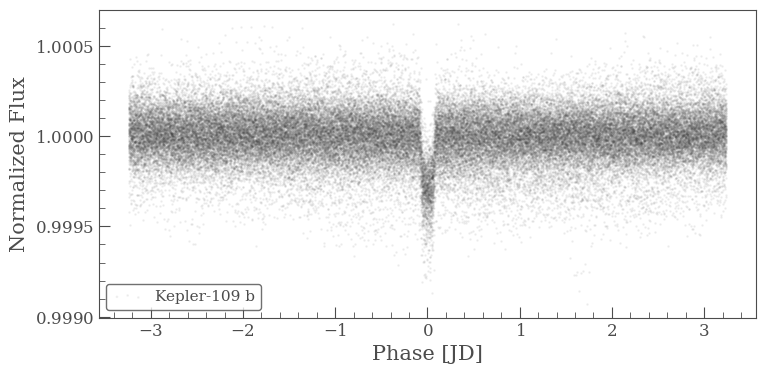

In [72]:
for i in range(len(planet_parameters)):
    ax = lc_clean.fold(period=planet_parameters[i]["pl_orbper"],
                 epoch_time=Time(planet_parameters[i]["pl_tranmid"],
                                 format="jd").bkjd).scatter(label=planet_parameters[i]["pl_name"], alpha=0.05)
    plt.show()

In [75]:
lc_final = np.ma.filled(lc_clean, fill_value=np.nan).remove_nans()

In [78]:
map_soln, model = fit.optimise_model(lc_final, param_lists)

65156 65156


optimizing logp for variables: [log_rho_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 430630.614578995 -> 431039.6657007168


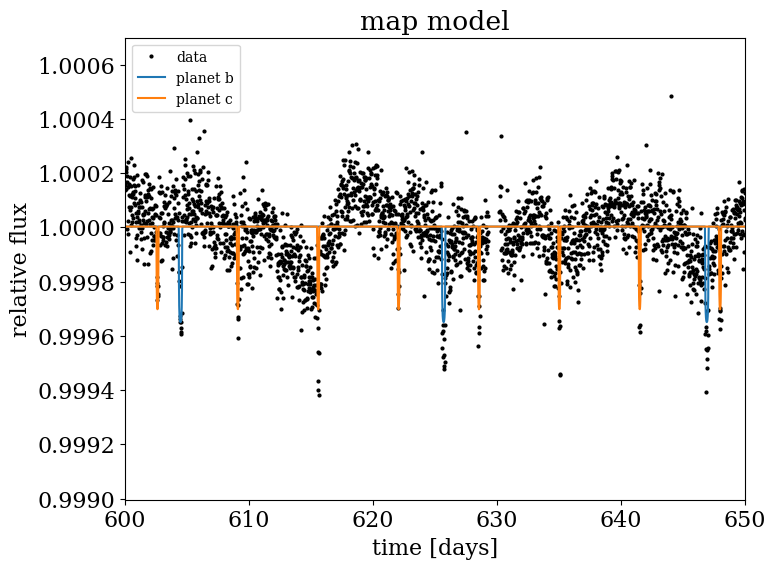

In [159]:
t = lc_final["time"].value
y = lc_final["flux"].value

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(t, y, ".k", ms=4, label="data")

for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i]+map_soln["mean"], lw=1.5, label="planet {0}".format(l)
    )
    
plt.xlim(600,650)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

In [160]:
trace = fit.sample_posteriors(model, map_soln, cores=12, chains=12)

Multiprocess sampling (12 chains in 12 jobs)
NUTS: [log_rho_star, b, r, u, logP, t0, mean]


/opt/anaconda3/envs/radius-valley/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/radius-valley/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/radius-valley/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/radius-valley/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/radius-valley/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/radius-valley/lib/python3.10/site-packages/sc

WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmp7e2tyrce/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmp7hl6ecdp/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmp7lhpfrgt/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmp7mh37dog/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmp7mz3g322/key.pk

WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpdu39kxyh/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpdu9fbzux/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpe7lg75ag/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpetjm97ow/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpetscek2y/key.pk

WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpltdp5rfr/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpltrczuuz/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpm_b0icy3/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpn6w034py/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpnbxrq1ya/key.pk

WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpwzr7pssw/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpx3evsr1s/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpx53xmnj3/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpx64k6kj0/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/suissa/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.10.12-64/tmpx9sa3j4l/key.pk

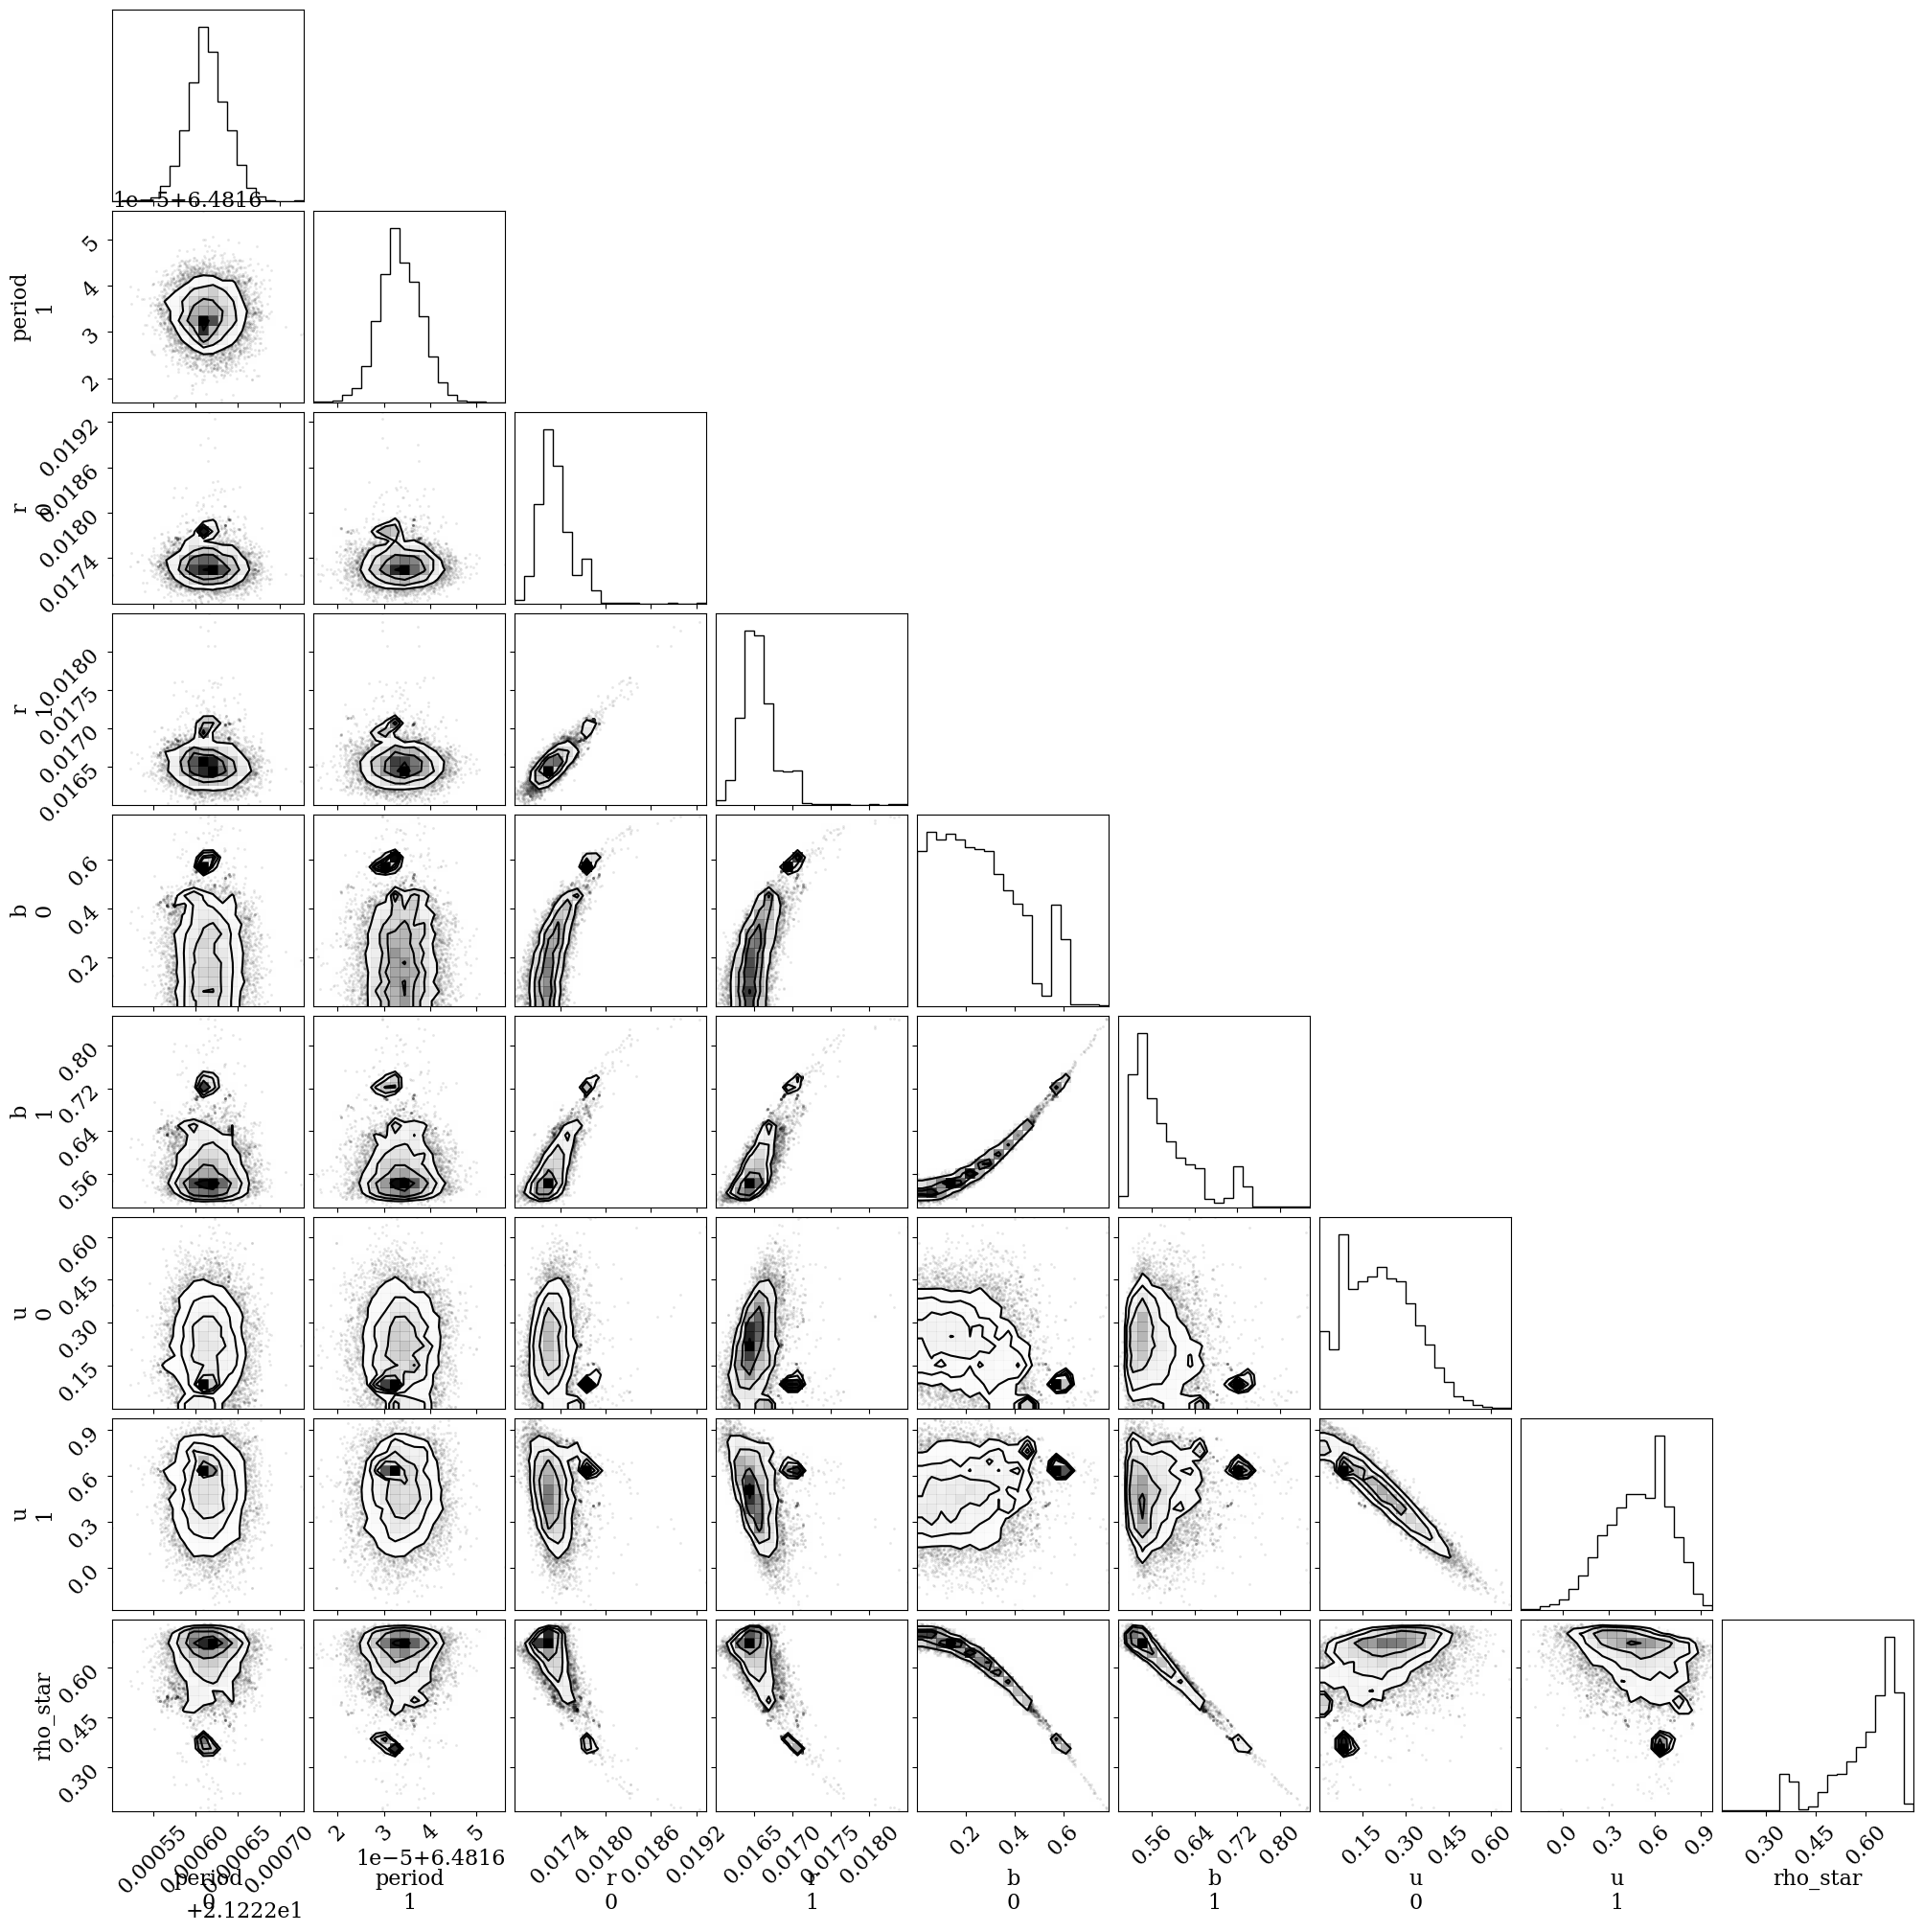

In [161]:
import corner
_ = corner.corner(
    trace,
    var_names=["period", "r", "b", "u", "rho_star"],
)
plt.show()

In [ ]:
# lower stellar density, longer transit. because we have transit duration, we have higher impact parameter 
# at higher impact parameter, star is fainter, radius of planet increases (apparently)

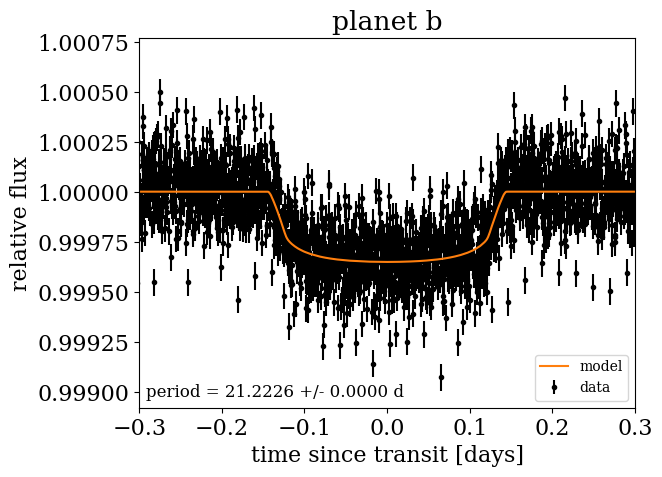

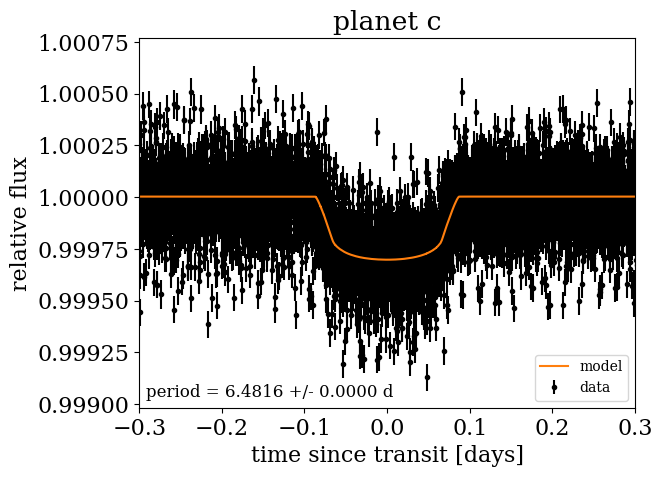

In [166]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    period_trace = trace.posterior["period"].values[:, :, n]
    p = np.median(period_trace)
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    lcs = trace.posterior["light_curves"].values
    other = np.median(lcs[:, :, :, (n + 1) % 2], axis=(0, 1))

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y - other, yerr=lc_final['flux_err'], fmt=".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = lcs[:, :, inds, n] + trace.posterior["mean"].values[:, :, None]
    pred = np.median(pred, axis=(0, 1))
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(period_trace), np.std(period_trace)
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

In [168]:
param_lists

{'pl_name': ['Kepler-109 c', 'Kepler-109 b'],
 'pl_letter': ['c', 'b'],
 'pl_orbper': [21.22265, 6.4816307],
 'pl_orbincl': [89.63, 87.06],
 'pl_orbeccen': [0.098, 0.11],
 'pl_trandep': [0.03599, 0.03015],
 'pl_tranmid': [2454970.5722, 2454955.97791],
 'pl_trandur': [6.4913, 3.649],
 'pl_ratror': [0.01734, 0.01686],
 'pl_imppar': [0.16, 0.58],
 'st_rad': [1.39, 1.39],
 'st_dens': [0.65, 0.65],
 'gaia_id': ['Gaia DR2 2101175933393051008', 'Gaia DR2 2101175933393051008'],
 'pl_rade': [2.65, 2.49],
 'berger_dens': [0.5557129614951429, 0.5557129614951429]}

In [169]:
map_soln

{'mean': array(1.00000287),
 't0': array([137.57416506, 122.97743324]),
 'logP': array([3.05506775, 1.86897271]),
 'u_quadlimbdark__': array([ 0.13289086, -1.8371183 ]),
 'r_interval__': array([-1.61375263, -1.67090603]),
 'b_impact__': array([-0.40994347,  0.48304977]),
 'log_rho_star': array(-0.27988392),
 'period': array([21.22262327,  6.48163449]),
 'u': array([0.20064454, 0.52954304]),
 'r': array([0.01744076, 0.01667204]),
 'b': array([0.40588324, 0.62877889]),
 'rho_star': array(0.52494775),
 'light_curves': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])}

In [170]:
map_soln_p1, model_p1 = fit.optimise_model(lc_final, xo_archive.transpose_parameters(planet_parameters[0:1]))

65156 65156


optimizing logp for variables: [log_rho_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 417678.4535282122 -> 417976.8028446831


In [172]:
map_soln_p2, model_p2 = fit.optimise_model(lc_final, xo_archive.transpose_parameters(planet_parameters[1:]))

65156 65156


optimizing logp for variables: [log_rho_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 421226.4726928816 -> 421356.99097514135


In [173]:
trace_p1 = fit.sample_posteriors(model_p1, map_soln_p1)

Multiprocess sampling (2 chains in 6 jobs)
NUTS: [log_rho_star, b, r, u, logP, t0, mean]


/opt/anaconda3/envs/radius-valley/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/radius-valley/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1236 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


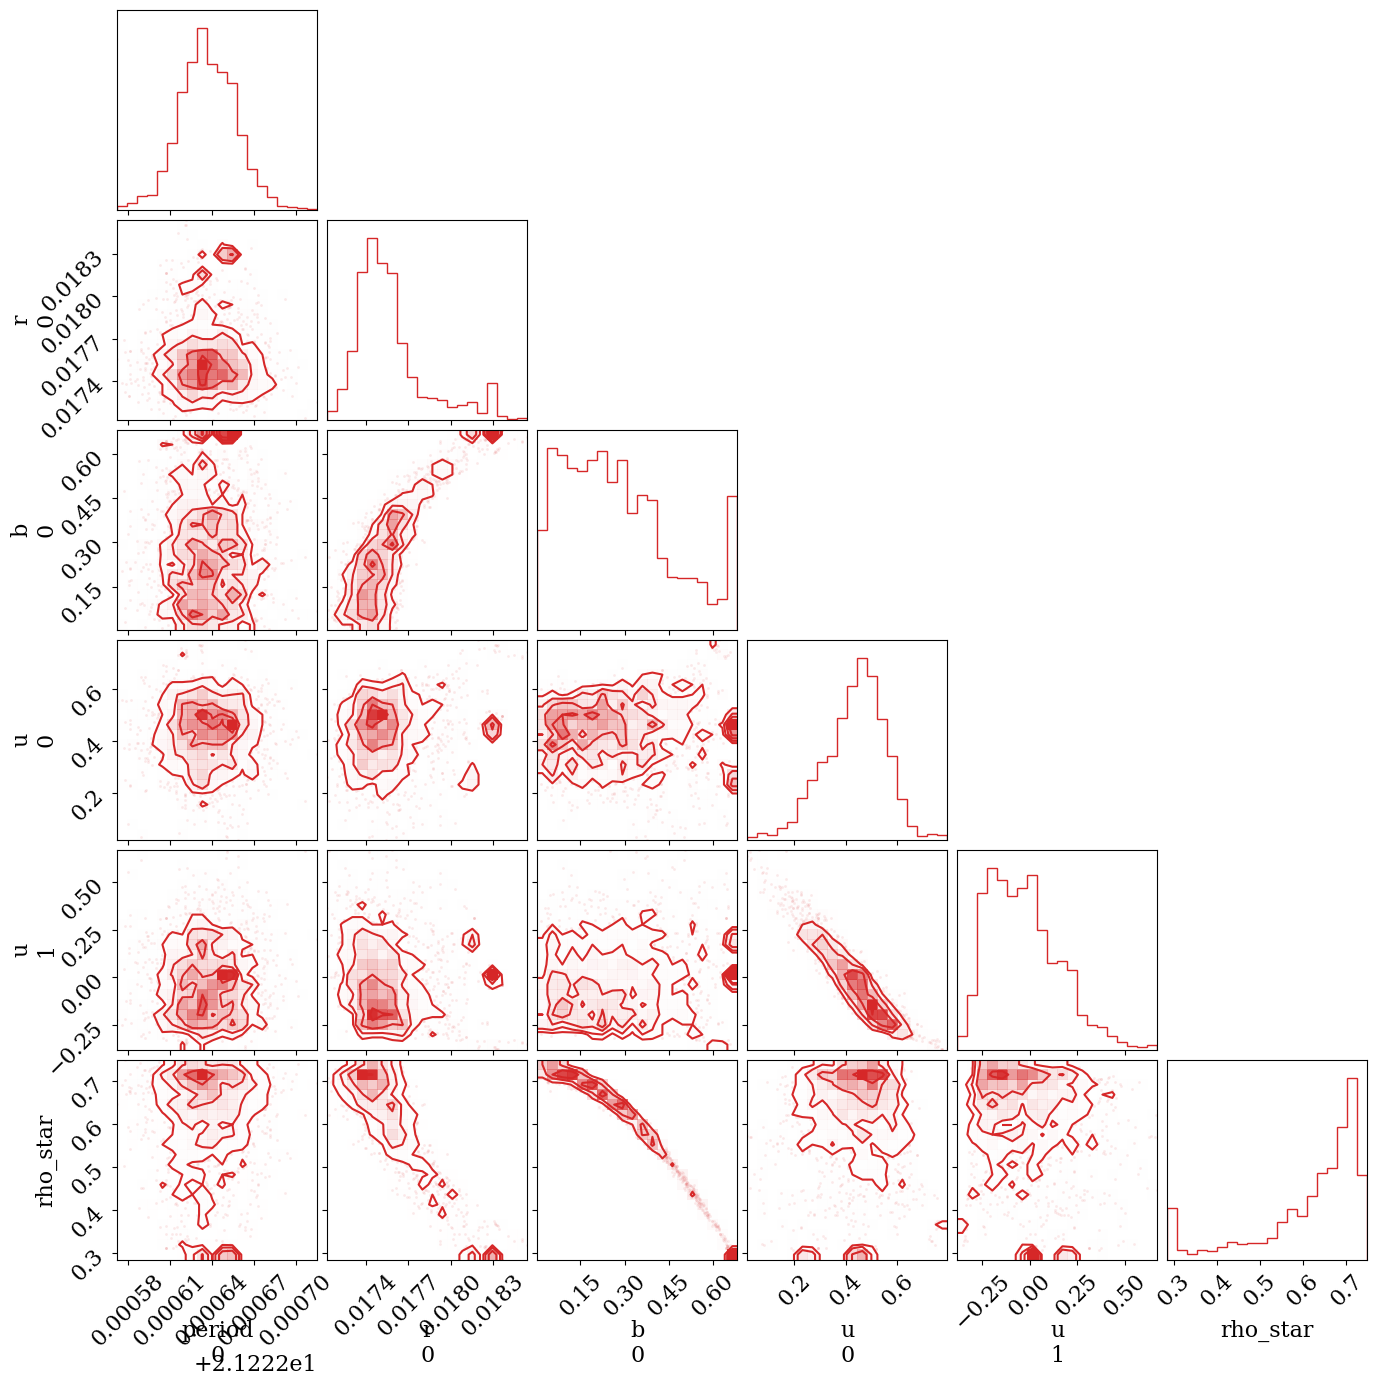

In [175]:
_ = corner.corner(
    trace_p1,
    var_names=["period", "r", "b", "u", "rho_star"],
    color="tab:red"
)
plt.show()


In [176]:
map_soln_p1

{'mean': array(0.99999621),
 't0': array([137.57379331]),
 'logP': array([3.05506824]),
 'u_quadlimbdark__': array([-1.6456808 ,  0.21843911]),
 'r_interval__': array([-1.60614924]),
 'b_impact__': array([-0.79629271]),
 'log_rho_star': array(-0.20678511),
 'period': array([21.22263364]),
 'u': array([ 0.44585599, -0.04374462]),
 'r': array([0.01754527]),
 'b': array([0.31627251]),
 'rho_star': array(0.62117632),
 'light_curves': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])}

In [177]:
map_soln

{'mean': array(1.00000287),
 't0': array([137.57416506, 122.97743324]),
 'logP': array([3.05506775, 1.86897271]),
 'u_quadlimbdark__': array([ 0.13289086, -1.8371183 ]),
 'r_interval__': array([-1.61375263, -1.67090603]),
 'b_impact__': array([-0.40994347,  0.48304977]),
 'log_rho_star': array(-0.27988392),
 'period': array([21.22262327,  6.48163449]),
 'u': array([0.20064454, 0.52954304]),
 'r': array([0.01744076, 0.01667204]),
 'b': array([0.40588324, 0.62877889]),
 'rho_star': array(0.52494775),
 'light_curves': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])}